# STEP 1: Import ALL the things!
[Following along here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics)

In [1]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

TensorFlow 2.x selected.


### (A) With Fraud Data

In [2]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### (B) With Loan Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("drive/My Drive/data")

In [0]:
raw_df_B = pd.read_csv('home-credit-default-risk/application_train.csv') 

## STEP 2: Examine Class Imbalance

In [8]:
### A
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [11]:
### B
repaid, defaulted = np.bincount(raw_df_B['TARGET'])
total = repaid + defaulted
print('Examples:\n    Total: {}\n    Defaulted: {} ({:.2f}% of total)\n'.format(
    total, defaulted, 100 * defaulted / total))


Examples:
    Total: 307511
    Defaulted: 24825 (8.07% of total)



# STEP 3: Clean, split and normalize the data


In [0]:
### A

# You don't want the `Time` column.
# The `Amount` column covers a huge range. Convert to log-space.

cleaned_df = raw_df.copy()
cleaned_df.pop('Time')
eps=0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

In [148]:
### B

# Temp "cleaning"

# cleaned_df_B = raw_df_B.copy()
# cols = ['TARGET','CNT_FAM_MEMBERS',
#  'CNT_CHILDREN',
#  'AMT_REQ_CREDIT_BUREAU_YEAR',
#  'OWN_CAR_AGE',
#  'DAYS_REGISTRATION',
#  'DAYS_ID_PUBLISH',
#  'DAYS_LAST_PHONE_CHANGE',
#  'DAYS_BIRTH','AMT_INCOME_TOTAL']      
# cleaned_df_B = pd.DataFrame(cleaned_df_B, columns=cols)

continuous_cols = ['TARGET']
for col in raw_df_B.columns:
  # if raw_df_B[col].value_counts()
  column = raw_df_B[col]
  if len(list(column.unique())) > 100:
    if column.isna().sum() < 100000:
      print(column.isna().sum())
      continuous_cols.append(col)

cont_df = pd.DataFrame(raw_df_B, columns = continuous_cols)

for col in cont_df.columns:
  median = cont_df[col].median()
  cont_df[col].fillna(median, inplace=True)

cont_df = cont_df.drop('SK_ID_CURR',axis=1)
cleaned_df_B = cont_df.copy()

0
0
0
12
278
0
0
0
0
660
60965
1


In [149]:
print(cleaned_df.shape)
print(cleaned_df_B.shape)

(284807, 30)
(307511, 12)


In [150]:
cleaned_df_B

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE
0,1,202500.0,406597.5,24700.5,351000.0,-9461,-637,-3648.0,-2120,0.262949,0.139376,-1134.0
1,0,270000.0,1293502.5,35698.5,1129500.0,-16765,-1188,-1186.0,-291,0.622246,0.535276,-828.0
2,0,67500.0,135000.0,6750.0,135000.0,-19046,-225,-4260.0,-2531,0.555912,0.729567,-815.0
3,0,135000.0,312682.5,29686.5,297000.0,-19005,-3039,-9833.0,-2437,0.650442,0.535276,-617.0
4,0,121500.0,513000.0,21865.5,513000.0,-19932,-3038,-4311.0,-3458,0.322738,0.535276,-1106.0
...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,157500.0,254700.0,27558.0,225000.0,-9327,-236,-8456.0,-1982,0.681632,0.535276,-273.0
307507,0,72000.0,269550.0,12001.5,225000.0,-20775,365243,-4388.0,-4090,0.115992,0.535276,0.0
307508,0,153000.0,677664.0,29979.0,585000.0,-14966,-7921,-6737.0,-5150,0.535722,0.218859,-1909.0
307509,1,171000.0,370107.0,20205.0,319500.0,-11961,-4786,-2562.0,-931,0.514163,0.661024,-322.0


In [0]:
### A 

def get_split_data(df, target_label):
  # Use a utility from sklearn to split and shuffle our dataset.
  train_df, test_df = train_test_split(df, test_size=0.2)
  train_df, val_df = train_test_split(train_df, test_size=0.2)

  # Form np arrays of labels and features.
  train_labels = np.array(train_df.pop(target_label))
  bool_train_labels = train_labels != 0
  val_labels = np.array(val_df.pop(target_label))
  test_labels = np.array(test_df.pop(target_label))

  train_features = np.array(train_df)
  val_features = np.array(val_df)
  test_features = np.array(test_df)

  return train_df, train_labels, bool_train_labels, val_labels, test_labels, train_features, val_features, test_features


In [0]:
train_df, train_labels, bool_train_labels, val_labels, test_labels, train_features, val_features, test_features = get_split_data(cleaned_df, 'Class')

In [0]:
train_df_B, train_labels_B, bool_train_labels_B, val_labels_B, test_labels_B, train_features_B, val_features_B, test_features_B = get_split_data(cleaned_df_B, 'TARGET')

In [0]:
def scale_and_plot(train_df, train_labels, val_labels, test_labels, train_features, val_features, test_features, bool_train_labels, col1, col2):
  scaler = StandardScaler()
  train_features = scaler.fit_transform(train_features)

  val_features = scaler.transform(val_features)
  test_features = scaler.transform(test_features)

  train_features = np.clip(train_features, -5, 5)
  val_features = np.clip(val_features, -5, 5)
  test_features = np.clip(test_features, -5, 5)

  print('Training labels shape:', train_labels.shape)
  print('Validation labels shape:', val_labels.shape)
  print('Test labels shape:', test_labels.shape)

  print('Training features shape:', train_features.shape)
  print('Validation features shape:', val_features.shape)
  print('Test features shape:', test_features.shape)
  pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
  neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

  sns.jointplot(pos_df[col1], pos_df[col2],
                kind='hex', xlim = (-5,5), ylim = (-5,5))
  plt.suptitle("Positive distribution")

  sns.jointplot(neg_df[col1], neg_df[col2],
                kind='hex', xlim = (-5,5), ylim = (-5,5))
  _ = plt.suptitle("Negative distribution")

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


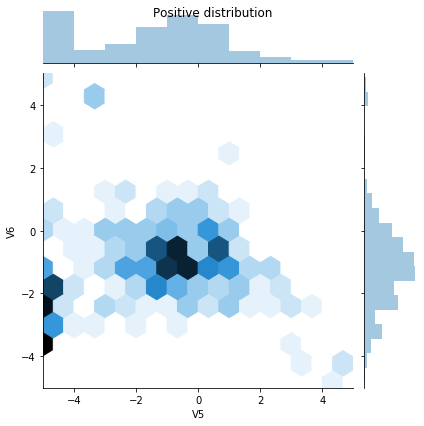

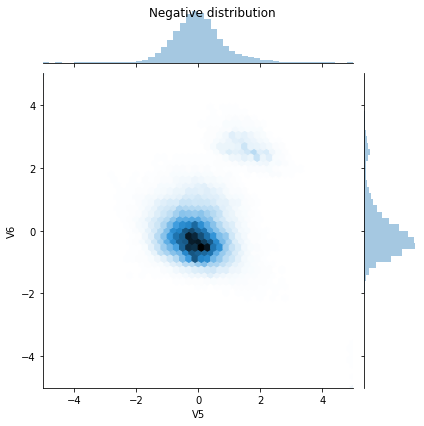

In [155]:
scale_and_plot(train_df, train_labels, val_labels, test_labels, train_features, val_features, test_features, bool_train_labels, 'V5', 'V6')

Training labels shape: (196806,)
Validation labels shape: (49202,)
Test labels shape: (61503,)
Training features shape: (196806, 11)
Validation features shape: (49202, 11)
Test features shape: (61503, 11)


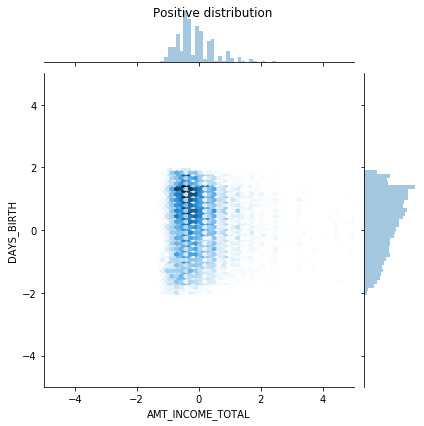

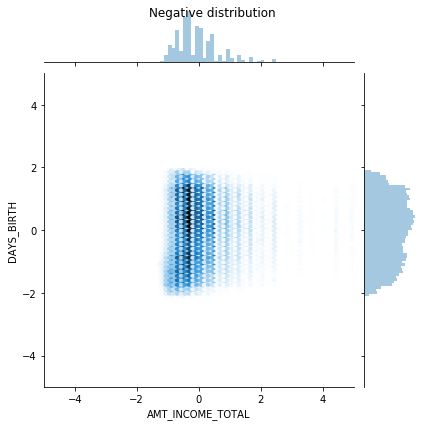

In [156]:
scale_and_plot(train_df_B, train_labels_B, val_labels_B, test_labels_B, train_features_B, val_features_B, test_features_B, bool_train_labels_B, 'AMT_INCOME_TOTAL','DAYS_BIRTH')

# STEP ? MAKE MODEL

In [0]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None, tf=train_features):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='tanh',
          input_shape=(tf.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [165]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model()
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 16)                480       
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [166]:
model.predict(train_features[:10])

array([[0.59295046],
       [0.1885627 ],
       [0.4439286 ],
       [0.15656826],
       [0.49566635],
       [0.38566503],
       [0.04725616],
       [0.42625585],
       [0.1431905 ],
       [0.660602  ]], dtype=float32)

In [167]:
model = make_model(tf = train_features_B)
model.summary()


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 16)                192       
_________________________________________________________________
dropout_14 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 17        
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


In [168]:
model.predict(train_features_B[:100])

array([[0.15034048],
       [0.2147896 ],
       [0.10096871],
       [0.2147896 ],
       [0.10096871],
       [0.1479379 ],
       [0.2147896 ],
       [0.2147896 ],
       [0.37626418],
       [0.14259915],
       [0.2147896 ],
       [0.2147896 ],
       [0.2147896 ],
       [0.2147896 ],
       [0.10096871],
       [0.10096871],
       [0.2147896 ],
       [0.2147896 ],
       [0.1479379 ],
       [0.1479379 ],
       [0.10096871],
       [0.2147896 ],
       [0.7713594 ],
       [0.2147896 ],
       [0.1885932 ],
       [0.10096871],
       [0.15034048],
       [0.2147896 ],
       [0.2147896 ],
       [0.10096871],
       [0.37626418],
       [0.15034048],
       [0.10096871],
       [0.10096871],
       [0.10096871],
       [0.37626418],
       [0.10096871],
       [0.15034048],
       [0.2147896 ],
       [0.10096871],
       [0.2147896 ],
       [0.2147896 ],
       [0.10096871],
       [0.2147896 ],
       [0.10096871],
       [0.10096871],
       [0.2147896 ],
       [0.150

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [144]:
  raw_df_B

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982,NaN,1,1,0,1,0,0,Sales staff,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,...

0
0
0
12
278
0
0
0
0
660
60965
1


In [0]:
cont_df = pd.DataFrame(raw_df_B, columns = continuous_cols)

for col in cont_df.columns:
  median = cont_df[col].median()
  cont_df[col].fillna(median, inplace=True)
# continuous_cols 

In [109]:
cont_df.isna().sum()

SK_ID_CURR                0
AMT_INCOME_TOTAL          0
AMT_CREDIT                0
AMT_ANNUITY               0
AMT_GOODS_PRICE           0
DAYS_BIRTH                0
DAYS_EMPLOYED             0
DAYS_REGISTRATION         0
DAYS_ID_PUBLISH           0
EXT_SOURCE_2              0
EXT_SOURCE_3              0
DAYS_LAST_PHONE_CHANGE    0
dtype: int64

In [100]:
raw_df_B['EXT_SOURCE_1']

0         0.083037
1         0.311267
2              NaN
3              NaN
4              NaN
            ...   
307506    0.145570
307507         NaN
307508    0.744026
307509         NaN
307510    0.734460
Name: EXT_SOURCE_1, Length: 307511, dtype: float64

In [143]:
train_df_B['TARGET']

KeyError: ignored